# Forensic Analysis Using CLIMADA: Flood Event Data from Saferplaces and RIM2D: EXAMPLE 2

## Introduction

In this analysis, we aim to conduct a **cost-benefit analysis** of a **single event** for different hypothetical adaptation measures, including a flood barrier, facade reinforcement, and a new building code. These measures can be evaluated across several different simulated flood events, such as an historical flood event and or an  100-year recurrence period event, for both current and future climate scenarios.

The impact calculations are based on flood map data output provided by **Saferplaces** and **RIM2D**, combined with their respective building data files. The methodology for calculating impact follows **Method 1** described in the notebook `CLIMADA-Saferplaces&RIM2D_example1`. 
In this approach, we create a reduced hazard set by calculating the mean water depth within a 20-meter buffer zone around each building. 

### Adaptation Measures

In the **CLIMADA framework**, [adaptation measures](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_MeasureSet.html#measureset-class) class are defined as objects that modify exposure, hazard, or impact function set objects. 

*Note: The **Measure** class in CLIMADA is designed to support such modifications, although, in the current version, the impact function set itself is not altered; instead, the **impact function ID** can be changed per building in the exposure object.*

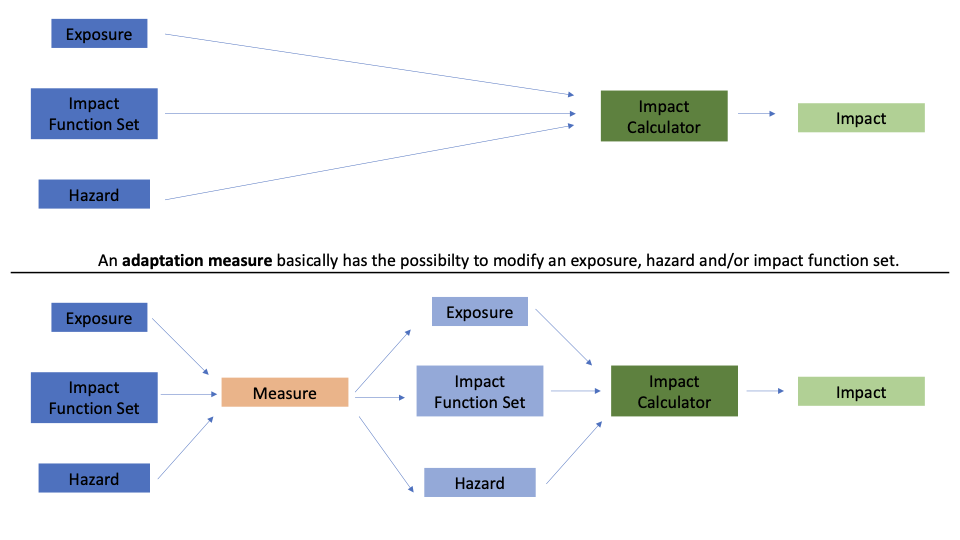

For this analysis, we explore several measures, each impacting the flood risk differently:

1. **No Measure**:
   - This represents the baseline scenario, where no adaptations are applied.

2. **Facade Reinforcement**:
   - Strengthens the building structure to reduce vulnerability to flooding.
   - This measure modifies the impact function, reducing the flood damage by a certain percentage (to be defined in the analysis).

3. **Barrier (Flood Barrier)**:
   - A physical barrier to prevent flooding.
   - The barrier's effectiveness is reflected in a new flood map, resulting in a modified hazard object. 
   - *Not available for the current RIM2D demo data*


4. **Building Code**:
   - A regulatory change that mandates building designs to be more flood-resilient.
   - This measure corresponds to a new impact function.

### Cost-Benefit Analysis

For each adaptation measure, we will calculate the **benefit** (the reduction in flood damage compared to the *No Measure* scenario) and the **cost-to-benefit ratio**. This will allow us to evaluate the economic feasibility of each measure by comparing the upfront costs of implementing the adaptation against the benefits in terms of reduced flood damage (note: for a single event).

The `.asc` file provided by RIM2D was converted to `.tif` using the following script:

```python
import subprocess

# Define the output .tif file name
asc_file = haz_raster_file
tif_file = haz_raster_file.replace('.asc', '.tif')

# Set the paths to the .asc and .tif files
asc_path = data_path / haz_folder / asc_file  # Path to the .asc file
tif_path = data_path / haz_folder / tif_file  # Path to the output .tif file

# Convert .asc to .tif using gdal_translate
orig_crs = 'EPSG:25832' # Provided by RIM2D for Denmark
cmd = ['gdal_translate', '-of', 'GTiff', '-a_srs', orig_crs, str(asc_path), str(tif_path)]
subprocess.run(cmd, check=True)
print(f"GeoTIFF saved as {tif_path}")

**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [1]:
from pathlib import Path
import os

# Define the base data path
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

# Define the Results folder inside the data path
results_path = data_path / 'Results'

# Create the Results folder if it doesn't exist
results_path.mkdir(parents=True, exist_ok=True)

# Get the current file name (dynamically from __file__ or manually set it)
# If running in Jupyter Notebook or an interactive environment, you can set the name manually
current_file_name = 'CLIMADA-Saferplaces&RIM2D_example2'

# Create a folder inside Results with the same name as the current working file
output_path = results_path / current_file_name
output_path.mkdir(parents=True, exist_ok=True)

print(f"Results will be stored in: {output_path}")


Results will be stored in: /Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA/Results/CLIMADA-Saferplaces&RIM2D_example2


Below tabel shows the availabkle demos to run.

In [2]:
import pandas as pd
from tabulate import tabulate

# Get the mapping file given the event and the region
# Define the path to the mapping file
mapping_file = data_path / 'Shared' / 'Mapping_DIRECTED.xlsx'
# Read the mapping file as a pandas dataframe
mapping_df = pd.read_excel(mapping_file, sheet_name='Mapping')

# Display the mapping file
print('The following demos are available:')
print(tabulate(mapping_df[['Demo', 'Region', 'Type', 'Data Provider',  'Climate Scenario', 'Event']].drop_duplicates(), headers='keys', tablefmt='psql'))


The following demos are available:
+----+--------+----------+---------+-----------------+--------------------+---------+
|    |   Demo | Region   | Type    | Data Provider   | Climate Scenario   | Event   |
|----+--------+----------+---------+-----------------+--------------------+---------|
|  0 |      1 | Rimini   | Coast   | Saferplaces     | Historical         | RT100   |
|  2 |      2 | Rimini   | Coast   | Saferplaces     | 2100               | RT100   |
|  4 |      3 | Rimini   | Coast   | Saferplaces     | 2050               | RT100   |
|  6 |      4 | Denmark  | Coast   | RIM2D           | Historical         | Bodil   |
|  7 |      5 | Denmark  | Coast   | RIM2D           | Historical         | RT100   |
|  8 |      6 | Denmark  | Coast   | RIM2D           | 2100               | RT100   |
|  9 |      6 | Denmark  | Pluvial | RIM2D           | Historical         | RT100   |
| 10 |      7 | Denmark  | Pluvial | RIM2D           | RCP4-5             | RT100   |
+----+--------+----

Determine the demo (#) to run.

In [3]:
# Parameters: Choose the demo number
demo_nr = 2

# Filter the mapping_df based on the selected demo number
demo_parameters = mapping_df[mapping_df['Demo'] == demo_nr].iloc[0]  # Get the first matching row for demo_nr
# Extract the parameters for the demo
Region = demo_parameters['Region']
Data_provider = demo_parameters['Data Provider']
Flood_Type = demo_parameters['Type']
Event = demo_parameters['Event']
Climate_Scenario = demo_parameters['Climate Scenario']

Some utility functions to generate the exposure object and the reduced hazard object (based on the exposured object and the .tif flood map)

In [4]:
from climada.entity import Exposures
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, box
import numpy as np
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix

# Function to load exposure data
def create_exposure_from_shp_file(shape_file, value_column=None, default_value=1):
    """
    Load exposure data from a shapefile, process it to be compatible with CLIMADA, and return an Exposures object.

    Parameters:
    - shape_file: Path to the shapefile to load.
    - value_column: Column name in the shapefile to use as the exposure value.
                    If not provided or doesn't exist, the 'default_value' will be used.
    - default_value: Default value to assign if 'value_column' is not provided or doesn't exist (default is 1).

    Returns:
    - Exposures: A CLIMADA Exposures object with processed data.
    """
    
    # Load the shapefile into a GeoDataFrame
    exp_gdf = gpd.read_file(shape_file)

    # Add a 'value' column to the GeoDataFrame (required by CLIMADA)
    if value_column is None or value_column not in exp_gdf.columns:
        exp_gdf['value'] = default_value
    else:
        exp_gdf['value'] = exp_gdf[value_column]

    # Store the original geometry in a new column
    exp_gdf['geometry_polygon'] = exp_gdf['geometry']

    # Set the geometry to the centroid of the building (useful for impact calculations later on)
    exp_gdf['geometry'] = exp_gdf['geometry'].centroid

    # Reproject the centroids back to EPSG:4326 (WGS84, in degrees) - CLIMADA default CRS
    exp_gdf = exp_gdf.to_crs(4326)

    # Set latitude and longitude from geometry
    exp_gdf['latitude'] = exp_gdf['geometry'].y
    exp_gdf['longitude'] = exp_gdf['geometry'].x

    # Define the exposure object
    exp = Exposures(exp_gdf)

    # Check the exposure object for consistency
    exp.check()

    # Return the Exposures object
    return exp


# Function to load the hazard data
def create_reduced_hazard_from_raster(exp, haz_raster_full_path, buffer_distance=20, frequency=None, event_id=None):
    """
    Function to create a hazard object from a raster file by calculating the mean water depth
    around the building polygons with a specified buffer distance.

    Parameters:
    - exp: The exposure GeoDataFrame containing building geometries.
    - haz_raster_full_path: File path to the hazard raster.
    - buffer_distance: Buffer distance for calculating mean water depth around buildings (in meters).
    - frequency: Frequency of the event (default is None, if None, a frequency of 1-in-1000 year is used).
    - event_id: Event ID (default is None, if None, an ID of np.arange(n_ev) is used).

    Returns:
    - hazard object: A CLIMADA hazard object based on the raster and building geometries.
    """

    # Hardcoded parameters
    haz_type = 'RF'
    intensity_unit='m'
    n_ev=1

    # Initialize default values if none provided
    if frequency is None:
        frequency = np.ones(n_ev) / 1000  # Default frequency
    if event_id is None:
        event_id = np.arange(n_ev, dtype=int)  # Default event ID

    # Step 1: Copy Exposure Data and Prepare for Processing
    haz_dummy_gdf = exp.gdf[['geometry', 'geometry_polygon']].copy()

    # Step 2: Open the Raster File and Get CRS
    with rasterio.open(haz_raster_full_path) as src:
        raster_crs = src.crs
        raster_bounds = src.bounds
        raster_nodata = src.nodata

    # Step 3: Apply Buffer to Building Geometries and Reproject to Match Raster CRS
    if haz_dummy_gdf.crs != raster_crs:
        haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
        print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")
    haz_dummy_gdf['geometry_polygon_buffered'] = haz_dummy_gdf['geometry_polygon'].buffer(buffer_distance)

    # Convert raster bounds to a Shapely Polygon for intersection checking
    raster_bounds_polygon = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

    # Step 4: Function to Calculate Mean Water Depth, Excluding Building Area
    def calculate_mean_water_excluding_building(geom, building_geom, src, raster_nodata, raster_bounds_polygon):
        # Check if the buffered building geometry intersects the raster area
        if geom.intersects(raster_bounds_polygon):
            buffer_minus_building = geom.difference(building_geom)
            if buffer_minus_building.is_empty:
                return 0
            geom_geojson = [mapping(buffer_minus_building)]
            out_image, _ = mask(src, geom_geojson, crop=True, nodata=raster_nodata)
            water_pixels = out_image.flatten()
            valid_water_pixels = water_pixels[(water_pixels != raster_nodata)]
            if valid_water_pixels.size == 0 or np.isnan(valid_water_pixels).all():
                return 0
            return np.nanmean(valid_water_pixels)
        else:
            return 0

    # Step 5: Apply the Mean Water Calculation to Each Buffered Building Geometry
    with rasterio.open(haz_raster_full_path) as src:
        haz_dummy_gdf['mean_water'] = haz_dummy_gdf.apply(
            lambda row: calculate_mean_water_excluding_building(
                row['geometry_polygon_buffered'], row['geometry_polygon'], src, raster_nodata, raster_bounds_polygon
            ),
            axis=1
        )

    # Step 6: Reproject Back to Geographic CRS (EPSG:4326)
    haz_dummy_gdf = haz_dummy_gdf.to_crs(4326)

    # Step 7: Create the Hazard Object for CLIMADA
    haz = Hazard(
        haz_type=haz_type,
        intensity=csr_matrix([haz_dummy_gdf["mean_water"]]),
        centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),
        units=intensity_unit,
        event_id=event_id,
        frequency=frequency
    )

    # Step 8: Validate the Hazard Object
    haz.check()

    return haz


For organosational purpose, the below table stores the exposure building file and hazard raster file corresponding different measures. 
If no shape file or raster file is given for the specific measure the *No measure* exposure and hazard objects will be used. This will become clearer further on. 

In [5]:
from tabulate import tabulate

# Get the mapping file given the event and the region
# Define the path to the mapping file
mapping_file = data_path / 'Shared' / 'Mapping_DIRECTED.xlsx'
# Read the mapping file as a pandas dataframe
mapping_df = pd.read_excel(mapping_file, sheet_name='Mapping')

# Filter the mapping file based on the region and event
# Filter out the mapping file
mapping_df = mapping_df[
    (mapping_df['Demo'] == demo_nr) &
    (mapping_df['Region'] == Region) & 
    (mapping_df['Data Provider'] == Data_provider) & 
    (mapping_df['Type'] == Flood_Type) & 
    (mapping_df['Event'] == Event) & 
    (mapping_df['Climate Scenario'] == Climate_Scenario)  # Correctly check for NaN values in 'Measure'
]

# Print the mapping file
print(tabulate(mapping_df, headers='keys', tablefmt='psql'))


+----+--------+----------+--------+-----------------+--------------------+---------+------------+-----------------+----------------+----------------------------------------------------------+---------------------------------------+
|    |   Demo | Region   | Type   | Data Provider   |   Climate Scenario | Event   | Measure    | Exposure        | Hazard         | Exposure File                                            | Hazard File                           |
|----+--------+----------+--------+-----------------+--------------------+---------+------------+-----------------+----------------+----------------------------------------------------------+---------------------------------------|
|  2 |      2 | Rimini   | Coast  | Saferplaces     |               2100 | RT100   | No measure | DMG_COAST121407 | WD_COAST121407 | Saferplaces/Exposure/DMG_COAST121407/DMG_COAST121407.shp | Saferplaces/Hazard/WD_COAST121407.tif |
|  3 |      2 | Rimini   | Coast  | Saferplaces     |               2100

Lets begin defining the exposure, hazard and impact function set for the no measure case.

In [6]:
# Parameters
measure_name = 'No measure' 

# Load the exposure data
exp = create_exposure_from_shp_file(shape_file =  data_path / mapping_df[mapping_df['Measure'] == measure_name]['Exposure File'].values[0], # Full path to the hazard raster file,
                         value_column= 'exposure' if Data_provider == 'Saferplaces' else 'value', # Column name with the exposure values#
                          )

# Create the hazard object
haz = create_reduced_hazard_from_raster(exp= exp, # Exposure object
                                      haz_raster_full_path = data_path / mapping_df[mapping_df['Measure'] == measure_name]['Hazard File'].values[0] # Full path to the hazard raster file,
                                        )


Reprojected GeoDataFrame to match the raster CRS: EPSG:32633


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_82143/2264206562.py:137: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),


Define the Impact function and impact function set

Here, we use the same residental impact function uside in the Saferplaces Rimini example. 

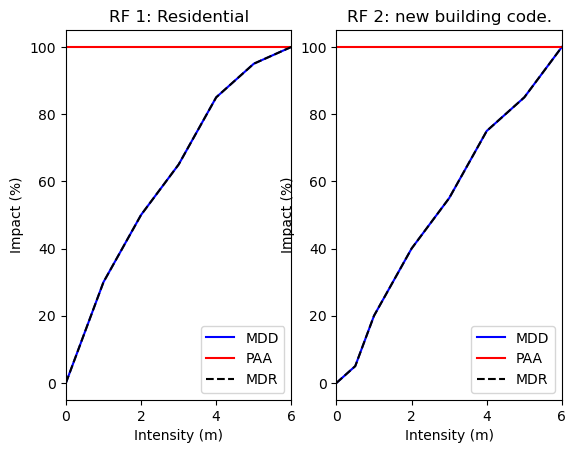

In [7]:
import numpy as np
from climada.entity import ImpactFuncSet

# Read the impact function set from excel (can also created manually)
impfset = ImpactFuncSet.from_excel(file_name = data_path / 'Shared' / 'Impact function sets' /'impact_fcn_set_Residental.xlsx' # Full path to the impact function set file
                                   )
#  Plot the impact functions
impfset.plot()

# Check the impact function set
impfset.check()

We need to assign the impact functions to the exposure points.

In [8]:
haz_type = 'RF'
exp.gdf[f'impf_{haz_type}'] = 1 # Assign the impact function ID to the exposure object

Calculate the impact and store the results in a data frame

In [9]:
from climada.engine import ImpactCalc

# Create the impact calculator
impcalc = ImpactCalc(exposures=exp, impfset=impfset, hazard=haz)

# Calculate the impacts
imp = impcalc.impact()

# The impact for the event
print(f'Impact for the event: {imp.at_event[0]}') # The impact for the single event

# Create a dictionary to store the impacts
impact_dict = {} 
impact_dict['No measure'] = imp

Impact for the event: 439904556.6868589


## Adaptation Measures

1. **No Measure**: Same exposure, hazard, and impact function set (already used for impact calculation).
2. **Facade**: Same exposure, same hazard, modified impact function.
3. **Barrier**: New exposure, new hazard, same impact function.
4. **Building Code**: Same exposure, same hazard, new impact function.

We begin creating the *Facade* measure

In [10]:
from climada.entity.measures import Measure

# Define measure
meas = Measure(
        name = 'Facade', # The name of the measure
        haz_type = haz_type, # The hazard type
        cost = 1e8, # Cost of the measure
        mdd_impact=(1, -0.15), # deceases the percentage of destroyed assets with 0.15
        paa_impact=(1, -0.1), # decreases the percentage of affected assets with 0.1  
        hazard_inten_imp=(1, -0.2), # reduces intensity by 0.2
        )

We can store the measure in a [Measure Set](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_MeasureSet.html#measureset-class), which is a container.

In [11]:
from climada.entity.measures import MeasureSet

meas_set = MeasureSet() # Create a measure set
meas_set.append(meas) # Append the measure to the measure set

Now we define the *Barrier* measure, which corresponds to a specific flood hazard map and building file (though it's not 100% certain if this is always the case, as there is another building shapefile in Saferplaces, and a measure could potentially change the building file).

Now, we create the *Barrier* measure

In [12]:
# Parameters
measure_name = 'Barrier'

# Get the specific shape file and flood map for the barrier
if mapping_df[mapping_df['Measure'] == measure_name].empty:
    print(f'The measure {measure_name} is not available for the selected region and event.')
else:
        # Load the exposure data
        barrier_exp = create_exposure_from_shp_file(shape_file =  data_path / mapping_df[mapping_df['Measure'] == measure_name]['Exposure File'].values[0], # Full path to the hazard raster file,
                                value_column= 'exposure' if Data_provider == 'Saferplaces' else 'value' # Column name with the exposure values
                                )
        # Create the hazard object
        barrier_haz = create_reduced_hazard_from_raster(exp= exp, # Exposure object
                                        haz_raster_full_path = data_path / mapping_df[mapping_df['Measure'] == measure_name]['Hazard File'].values[0] # Full path to the hazard raster file,
                                                )
        # Save the barrier hazard and barrier exposure to the output folder
        barrier_exp.write_hdf5(output_path / 'barrier_exp.h5')
        barrier_haz.write_hdf5(output_path / 'barrier_haz.h5')

        # Define measure
        meas = Measure(
                name = measure_name,
                haz_type = haz_type,
                cost = 5e8,
                exposures_set = output_path / 'barrier_exp.h5',
                hazard_set = output_path / 'barrier_haz.h5'
                )

        # Append the measure to the measure set
        meas_set.append(meas)

Reprojected GeoDataFrame to match the raster CRS: EPSG:32633


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_82143/2264206562.py:137: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),


Now, we create the *Building Code* measure

In [13]:
# Define measure
meas = Measure(
        name = 'Building Code', # The name of the measure
        haz_type = haz_type, # The hazard type
        cost = 3e7, # Cost of the measure
        imp_fun_map = '1to2' # Cnage impact function id from 1 to 2 for all buildings
        )

# Append the measure to the measure set
meas_set.append(meas)

Now we calculate the impact for each measure.

In [14]:
# Calculate the impact for all measures
for meas in meas_set.get_measure(haz_type):

    # new impact functions
    new_exp, new_impfs, new_haz = meas.apply(exp, impfset, haz)

    # Calculate the impact
    impcalc = ImpactCalc(exposures=new_exp, impfset=new_impfs, hazard=new_haz)
    impact_dict[meas.name] = impcalc.impact()


Calculate the Benefit-to-Cost and store all the results in data frame for comparison

In [16]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Create a list to hold the dictionary entries for each row
data_dict = []

# Get the impact for the no measure case
imp_no_measure = impact_dict['No measure'].at_event[0]

# Loop through the impact dictionary to calculate the metrics
for key, value in impact_dict.items():
    # Metrics
    imp_meas = value.at_event[0]  # Impact is the impact of the measure
    cost = meas_set.get_measure(haz_type=None, name=key)[0].cost if key != 'No measure' else 0  # Cost of the measure
    benefit = imp_no_measure - imp_meas  # Benefit is the difference between the no measure and the measure
    benefit_to_cost = benefit / cost if key != 'No measure' else np.nan  # Cost-to-Benefit ratio

    # Add the dictionary directly to the data list
    data_dict.append({
        'Measure': key,
        'Impact': imp_meas,
        'Cost Measure': cost,
        'Benefit': benefit,
        'Benefit-to-Cost': benefit_to_cost
    })

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(data_dict)

# Print the unique combination of Region, Data Provider, Type, Event, Climate Scenario
print('Forensics Analysis:')
print(tabulate(mapping_df[['Demo', 'Region', 'Type', 'Data Provider', 'Event', 'Climate Scenario']].drop_duplicates(), headers='keys', tablefmt='psql'), '\n')

# Print the metrics DataFrame using tabulate for pretty printing
print(tabulate(metrics_df, headers='keys', tablefmt='psql'))


Forensics Analysis:
+----+--------+----------+--------+-----------------+---------+--------------------+
|    |   Demo | Region   | Type   | Data Provider   | Event   |   Climate Scenario |
|----+--------+----------+--------+-----------------+---------+--------------------|
|  2 |      2 | Rimini   | Coast  | Saferplaces     | RT100   |               2100 |
+----+--------+----------+--------+-----------------+---------+--------------------+ 

+----+---------------+-------------+----------------+-------------+-------------------+
|    | Measure       |      Impact |   Cost Measure |     Benefit |   Benefit-to-Cost |
|----+---------------+-------------+----------------+-------------+-------------------|
|  0 | No measure    | 4.39905e+08 |          0     | 0           |         nan       |
|  1 | Facade        | 9.76779e+07 |          1e+08 | 3.42227e+08 |           3.42227 |
|  2 | Barrier       | 1.8859e+08  |          5e+08 | 2.51315e+08 |           0.50263 |
|  3 | Building Code | 2.